# Topic extraction

Using `tomotopy`.
Comparing different algorithms - LDA, PA, DMR, CTM.

In [49]:
import psycopg2
import numpy
from time import time
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim

n_samples = 100000
train_time = 1800

In [46]:
def log(message):
    print(message, flush=True)

In [41]:
t0 = time()
print("Connecting to DB...")
conn = psycopg2.connect("dbname='peanut_prod' user='mezis' host='frolic.local' password='av85ck4g'")
cur = conn.cursor()

print("Loading dataset...")
cur.execute(f"""
    SELECT CONCAT_WS(' ', title, body) AS text
    FROM post p
    JOIN users u ON u.id = p.author_id
    --JOIN post_stats ps ON ps.id = p.id AND ps.view_count > 50
    WHERE TRUE
      AND u.account_status = 'active'
      AND p.status = 'active'
    ORDER BY p.id DESC
    LIMIT {n_samples}
""")
data_samples = [row[0] for row in cur.fetchall()]

# remove the shortest 10% of documents
data_samples = [s for s in data_samples if len(s) > 45]

print("done in %0.3fs." % (time() - t0))
print("%d samples" % len(data_samples))

Connecting to DB...
Loading dataset...
done in 0.597s.
89441 samples


In [42]:
print("Preparing text preprocessing...")
import re

t0 = time()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

class MyPreprocessor:
    def __call__(self, doc):
        return doc.lower()

class MyTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
        self.stopwords = frozenset(
            nltk.corpus.stopwords.words('english') + """
                n't
                anyone
                everyone
                feel like want get
            """.split()
        )
        self.re = re.compile(r"[a-z0-9]")
        
    def __call__(self, doc):
        return [token for token in [self.filter(token) for token in self.tokenize(doc)] if token]
    
    def tokenize(self, doc):
        return nltk.word_tokenize(doc.lower());
    
    def filter(self, token):
        if token in self.stopwords:
            return
        if not self.re.match(token):
            return
        return self.wnl.lemmatize(token)

print("done in %0.3fs." % (time() - t0))

Preparing text preprocessing...
done in 0.003s.


[nltk_data] Downloading package punkt to /home/mezis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mezis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mezis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mezis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [43]:
from tqdm import tqdm
import multiprocessing

print('Tokenizing...')
tokenizer = MyTokenizer()
data_tokenized = []
pool = multiprocessing.Pool(processes=8)
for tokenized in pool.imap_unordered(tokenizer, tqdm(data_samples)):
    data_tokenized.append(tokenized)
    
print("Building gensim corpus...")
gensim_dictionary = gensim.corpora.Dictionary(data_tokenized)

Tokenizing...


100%|██████████| 89441/89441 [00:09<00:00, 9427.87it/s] 


Building gensim corpus...


In [50]:
import tomotopy as tp

model0 = tp.LDAModel(
    tw=tp.TermWeight.ONE,
    k=20, 
    min_cf=200,
    alpha=(1./len(data_samples)),
    eta=(1./len(data_samples)),
    seed=0
)

model1 = tp.PAModel(
    tw=tp.TermWeight.ONE,
    k1=7, k2=20, 
    min_cf=200,
    alpha=(1./len(data_samples)),
    eta=(1./len(data_samples)),
    seed=0
)

model2 = tp.DMRModel(
    tw=tp.TermWeight.ONE,
    min_cf=200,
    k=20, 
    alpha=(1./len(data_samples)),
    eta=(1./len(data_samples)),
    seed=0
)

model3 = tp.CTModel(
    tw=tp.TermWeight.ONE,
    k=20, 
    min_cf=200,
    seed=0
)

models = [model0, model1, model2, model3]

for tokens in tqdm(data_tokenized):
    for m in models:
        m.add_doc(tokens)

100%|██████████| 89441/89441 [00:03<00:00, 25239.79it/s]


In [51]:
def train_for(model, seconds=30.0):
    with tqdm(total=seconds) as bar:
        t_start = time()
        t_prev = t_start
        while t_prev < t_start + seconds:
            model.train(1)
            t_cur = time()
            bar.update(t_cur - t_prev)
            t_prev = t_cur

for i, model in enumerate(models):
    log(f'Training model {i}')
    train_for(model, seconds=train_time)

Training model 0


 51%|█████     | 921.6759629249573/1800 [15:21<14:38,  1.00it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████▉| 1799.9688246250153/1800 [29:59<00:00,  1.00it/s]/home/mezis/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
100%|██████████| 1800.0179941654205/1800 [30:00<00:00,  1.00s/it]

Training model 1



 74%|███████▍  | 1339.5286462306976/1800 [22:19<07:40,  1.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [52]:
%config InlineBackend.figure_format = 'retina'

def make_wordcloud(data, n_words=50, w=400, h=300):

    return wordcloud.WordCloud(
        width = w, height = h, 
        background_color = 'white',
        prefer_horizontal = 1,
        relative_scaling = 0.1,
        min_font_size = h/40
    ).generate_from_frequencies(data) 

def render_clouds(model, n_words=50):
    fig=plt.figure(figsize=(16, 12))
    columns = 5
    rows = 4
    
    words = {} # topic idx -> word -> frequency
    for i in range(0, columns*rows):
        words[i] = dict(model.get_topic_words(i, top_n=n_words))

    images = {} # topic idx -> image
    for i in range(0, columns*rows):        
        images[i] = make_wordcloud(words[i])
    
    for i in range(0, columns*rows):
        img = images[i]
        subp = fig.add_subplot(rows, columns, i+1)
        subp.set_title("Topic #%d" % (i,))
#         subp.set_title("Topic #%d (%d%% posts)" % (i, 100 * counts[i] / counts.sum()))
        plt.imshow(img)
        plt.axis("off")
        plt.tight_layout(pad = 3.0)
    plt.show()

In [53]:
class ModelWrapper:
    def __init__(self, model):
        self.model_ = model
        self.type_ = type(model)
    
    def k(self):
        if self.type_ == tp.PAModel:
            return self.model_.k2
        else:
            return self.model_.k
    
    def get_topics(self, doc, **kwargs):
        if self.type_ == tp.PAModel:
            return doc.get_sub_topics(**kwargs)
        else:
            return doc.get_topics(**kwargs)   

In [54]:
# https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a
# https://github.com/ecoronado92/towards_data_science/blob/master/hdp_example/scripts/model_funcs.py

def get_topic_words(model, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    model:obj -> trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    w = ModelWrapper(model)
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = range(w.k())
    
    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        try:
            if not model.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        except AttributeError: 
            pass
        
        topic_wp = model.get_topic_words(k, top_n=top_n)

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, vocab, documents, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    vocab: gensim.corpora.Dictionary
    documents: list of list of strings
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    3-tuple,
        float -> coherence value
        float list -> per-topic coherence
        float list -> per-topic coherence deviation
    '''
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens = [w for w,p in tups]
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    cm = gensim.models.CoherenceModel(
        topics=topic_list,
        dictionary=vocab,
        texts=documents, 
        coherence=coherence_type,
        processes=8)
    
    score = cm.get_coherence()
    score_per_topic = cm.get_coherence_per_topic(with_std=True)
    return (
        score,
        [x for x,y in score_per_topic],
        [y for x,y in score_per_topic],
    )


In [55]:
#
# FIXME:
# only consider a topic when its score is > some threshold (2x 1/20 ?)


def topic_counts(model, top_n):
    """For each topic, count posts where the topic figure in the `top_n` topics
    
    Returns:
    dict of topic_id (int), posts (int)
    """
    counts = {}
    w = ModelWrapper(model)
    for k in range(w.k()):
        counts[k] = 0
    for doc in tqdm(model.docs):
        for k, v in w.get_topics(doc, top_n=top_n):
            counts[k] += 1
    return counts

In [56]:
def plot_analysis(model, coherence, axes):
    c1 = topic_counts(model, top_n=1)
    c3 = topic_counts(model, top_n=3)

    rows = 3
    
    axes[0].bar(c1.keys(), c1.values())
    axes[0].set_xticks(list(c1.keys()))
    axes[0].grid()
    axes[0].set_title('Posts per topic (top-1 topic)')

    axes[1].bar(c3.keys(), c3.values())
    axes[1].set_xticks(list(c3.keys()))
    axes[1].grid()
    axes[1].set_title('Posts per topic (top-3 topic)')

    x = range(len(coherence[1]))
    axes[2].bar(
        x,
        coherence[1],
        yerr=coherence[2])
    axes[2].set_xticks(x)
    axes[2].grid()
    axes[2].set_title('Per-topic coherence')

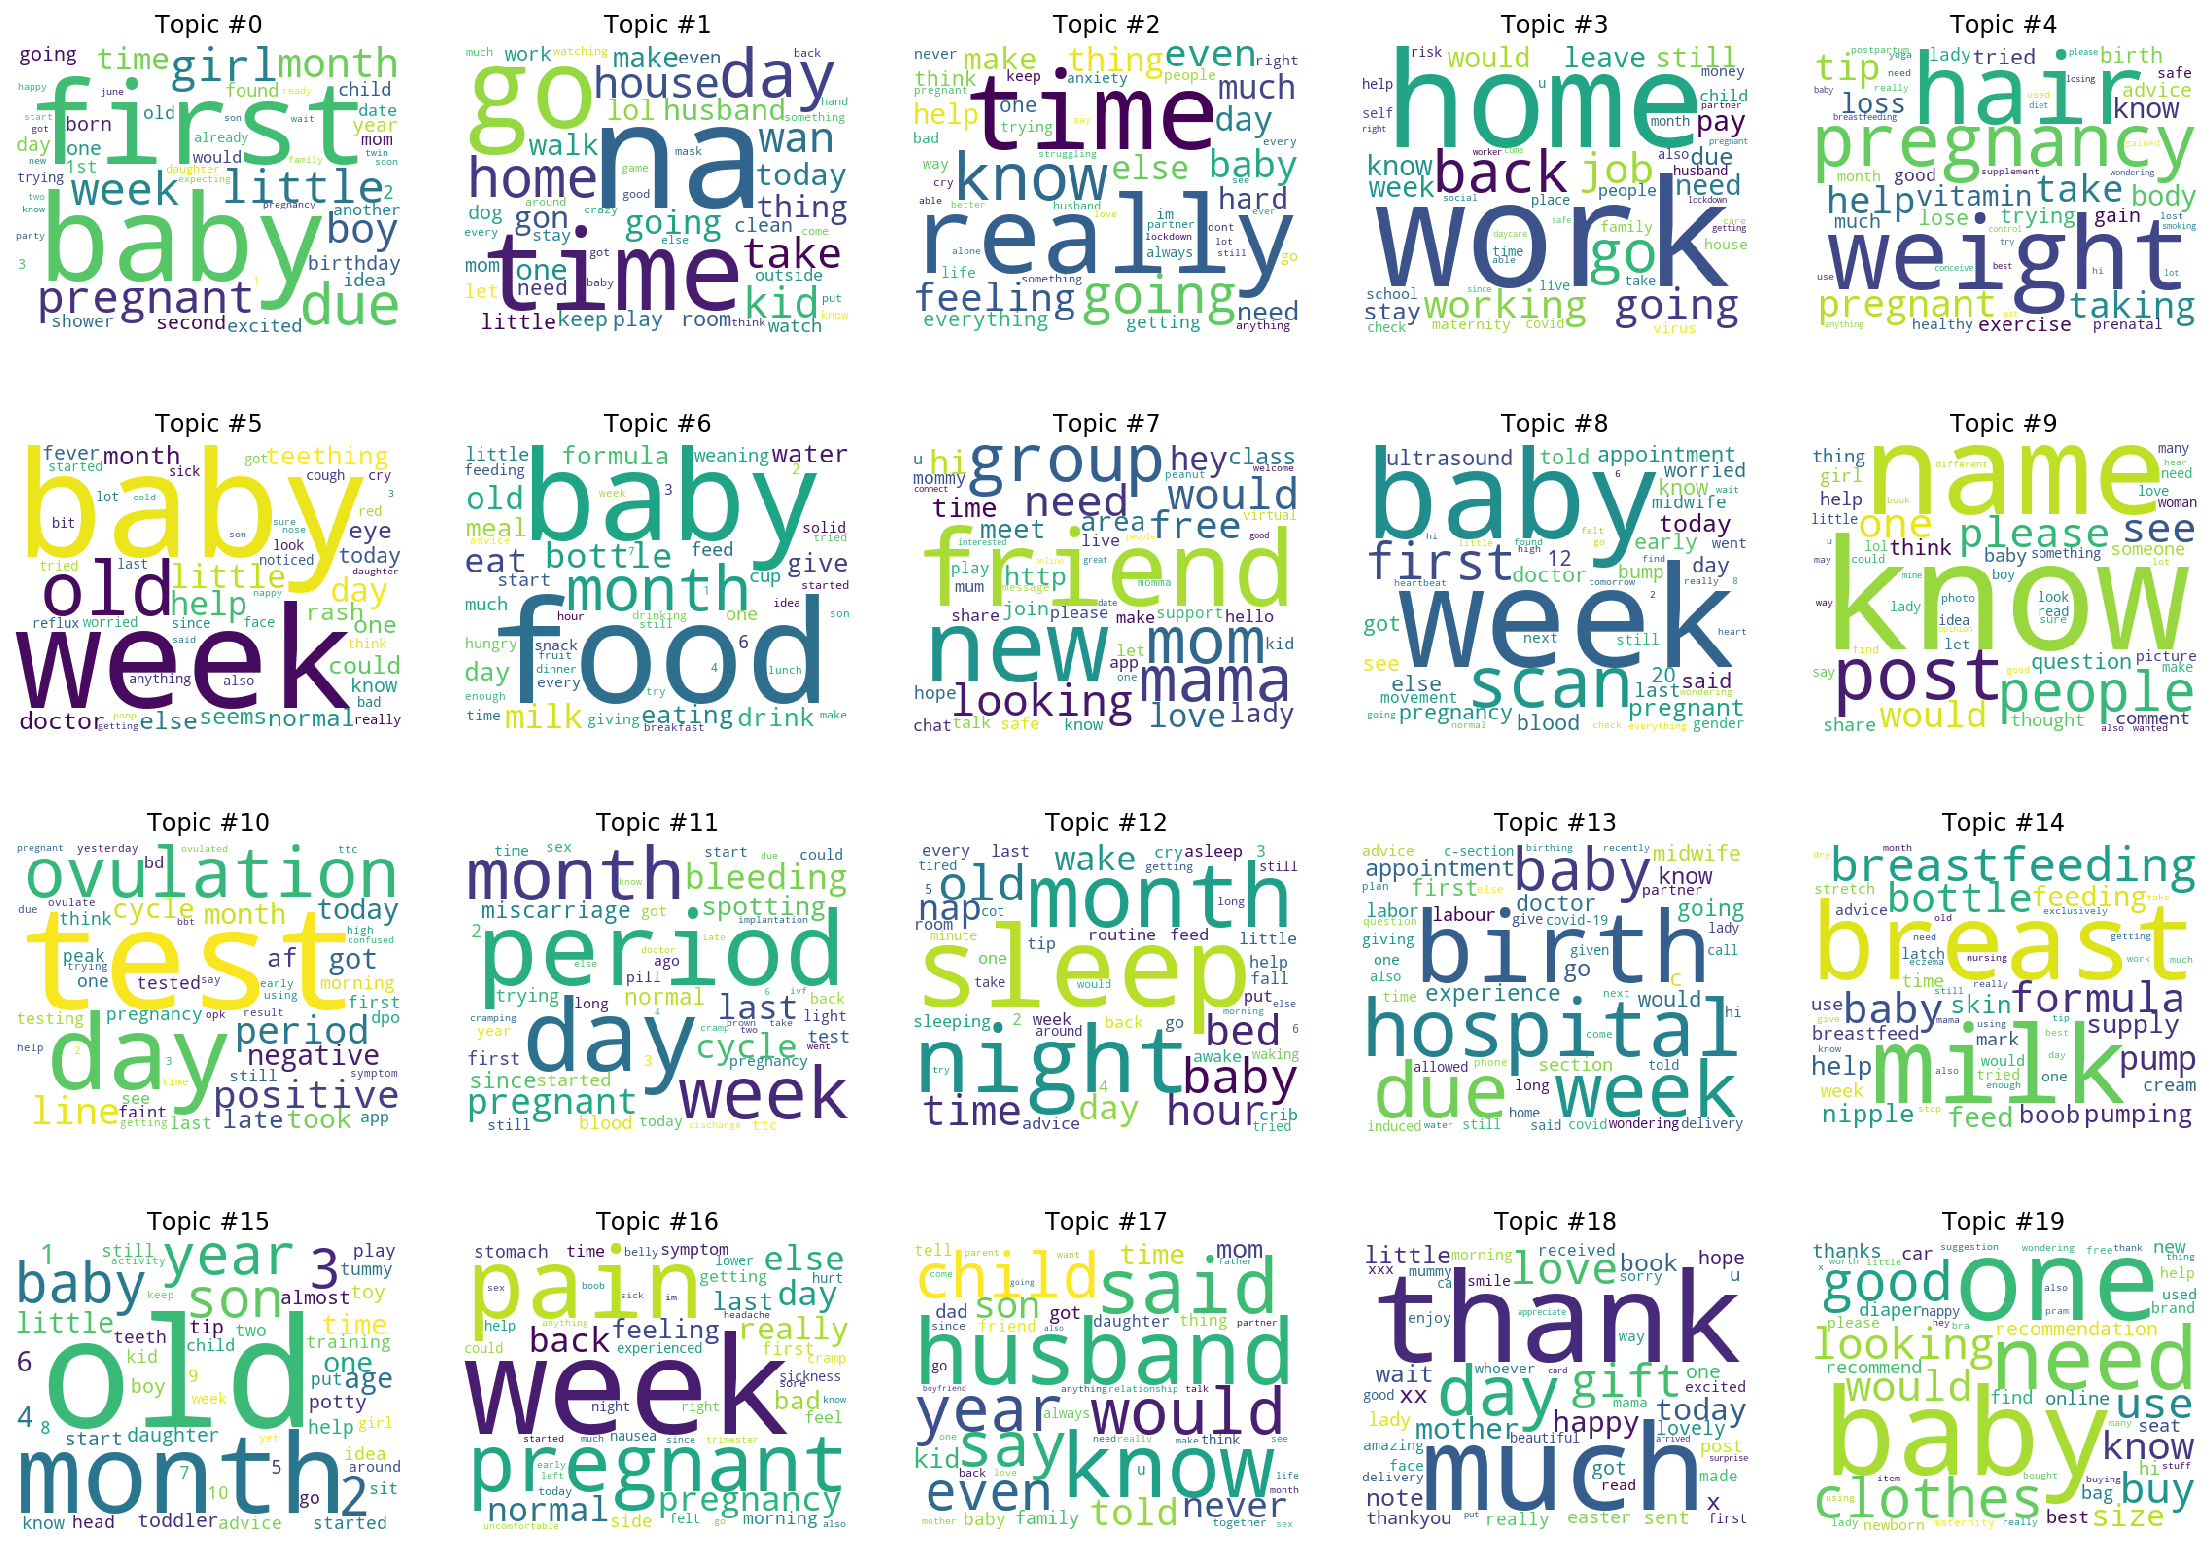

In [57]:
render_clouds(model0)

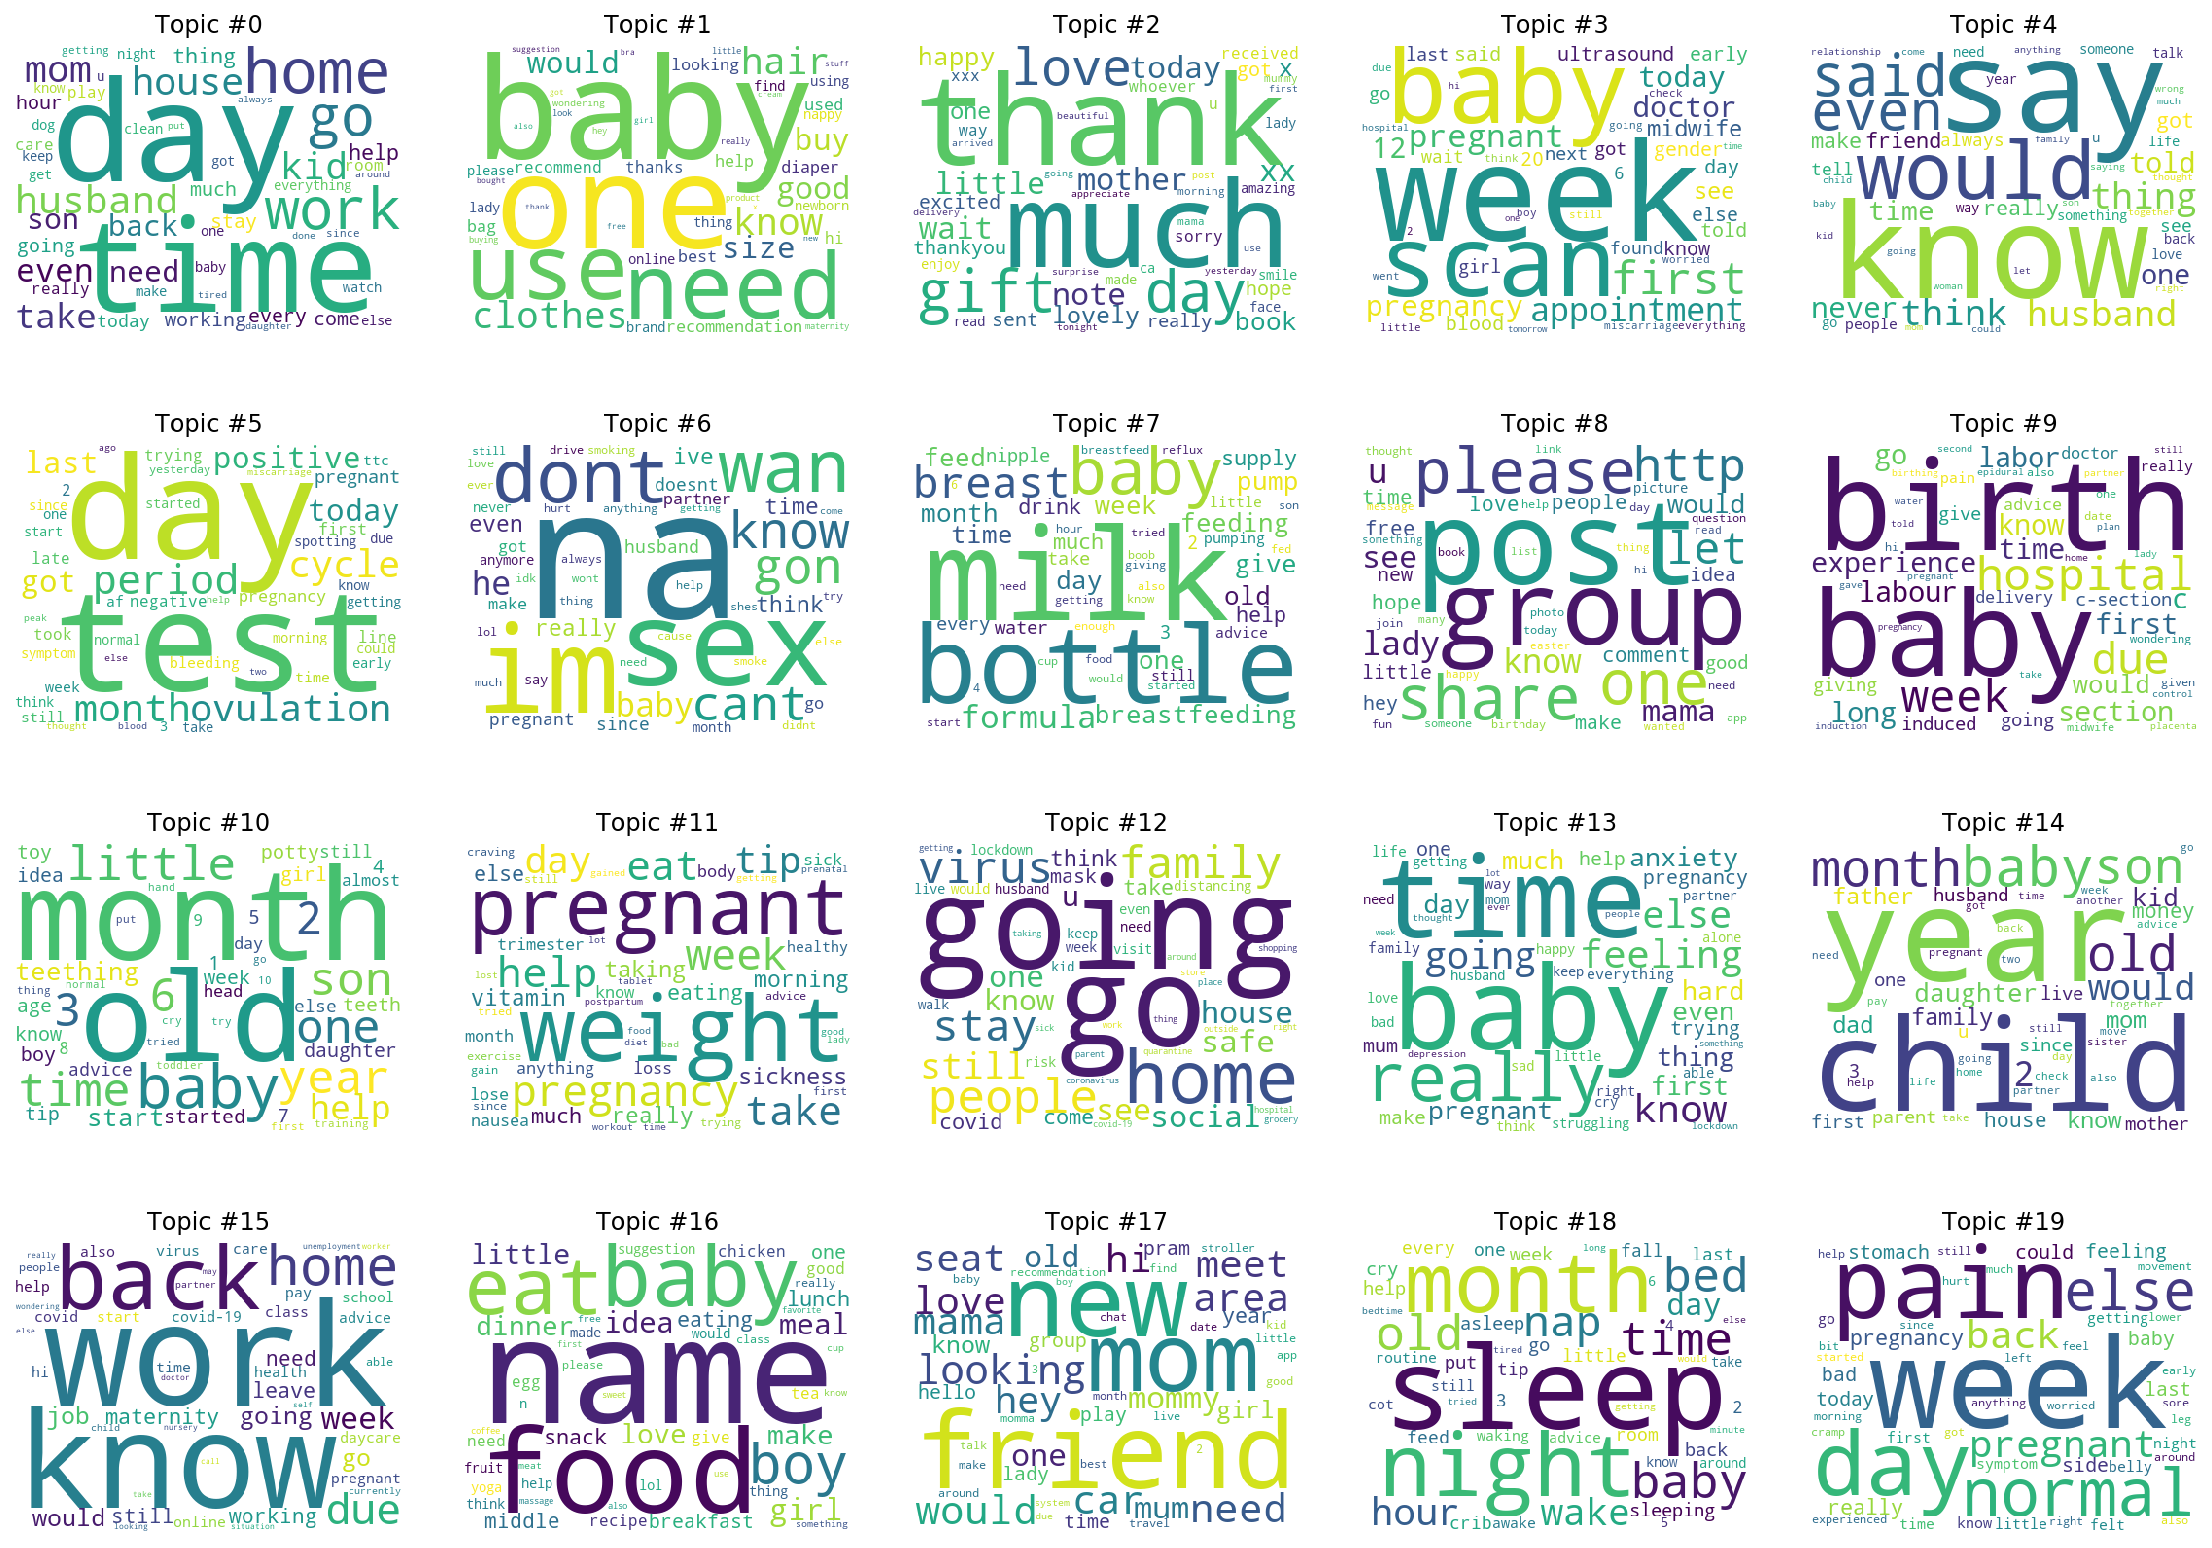

In [58]:
render_clouds(model1)

In [59]:
for k in range(model1.k1):
#     st = [k2 for k2,_ in model1.get_sub_topics(k)]
    st = model1.get_sub_topics(k, top_n=3)
    print('Super topic %d -> sub topics %s' % (k, st))

Super topic 0 -> sub topics [(4, 0.10287313908338547), (5, 0.08635581284761429), (19, 0.07630037516355515)]
Super topic 1 -> sub topics [(4, 0.10807020217180252), (5, 0.08293228596448898), (19, 0.07991956174373627)]
Super topic 2 -> sub topics [(4, 0.11052821576595306), (19, 0.0779406726360321), (5, 0.0773506686091423)]
Super topic 3 -> sub topics [(4, 0.10445470362901688), (5, 0.07955893874168396), (19, 0.07704515755176544)]
Super topic 4 -> sub topics [(4, 0.1077006459236145), (5, 0.0773436427116394), (19, 0.07540901005268097)]
Super topic 5 -> sub topics [(4, 0.10510271042585373), (5, 0.07980010658502579), (19, 0.07762607932090759)]
Super topic 6 -> sub topics [(4, 0.10753270983695984), (5, 0.0813874825835228), (19, 0.07789019495248795)]


In [84]:
# x = zip(model1.vocabs, model1.get_topic_word_dist(7))
# sorted(x, key=lambda t: -t[1])
print(type(model1))
x = []
for k in range(model1.k2):
    x.append(model1.get_topic_word_dist(k))
x = numpy.array(x)
x.shape
numpy.sum(x, axis=0)

<class 'tomotopy.PAModel'>


array([0.33501093, 0.2339746 , 0.19859043, ..., 0.00304036, 0.00344353,
       0.00200309])

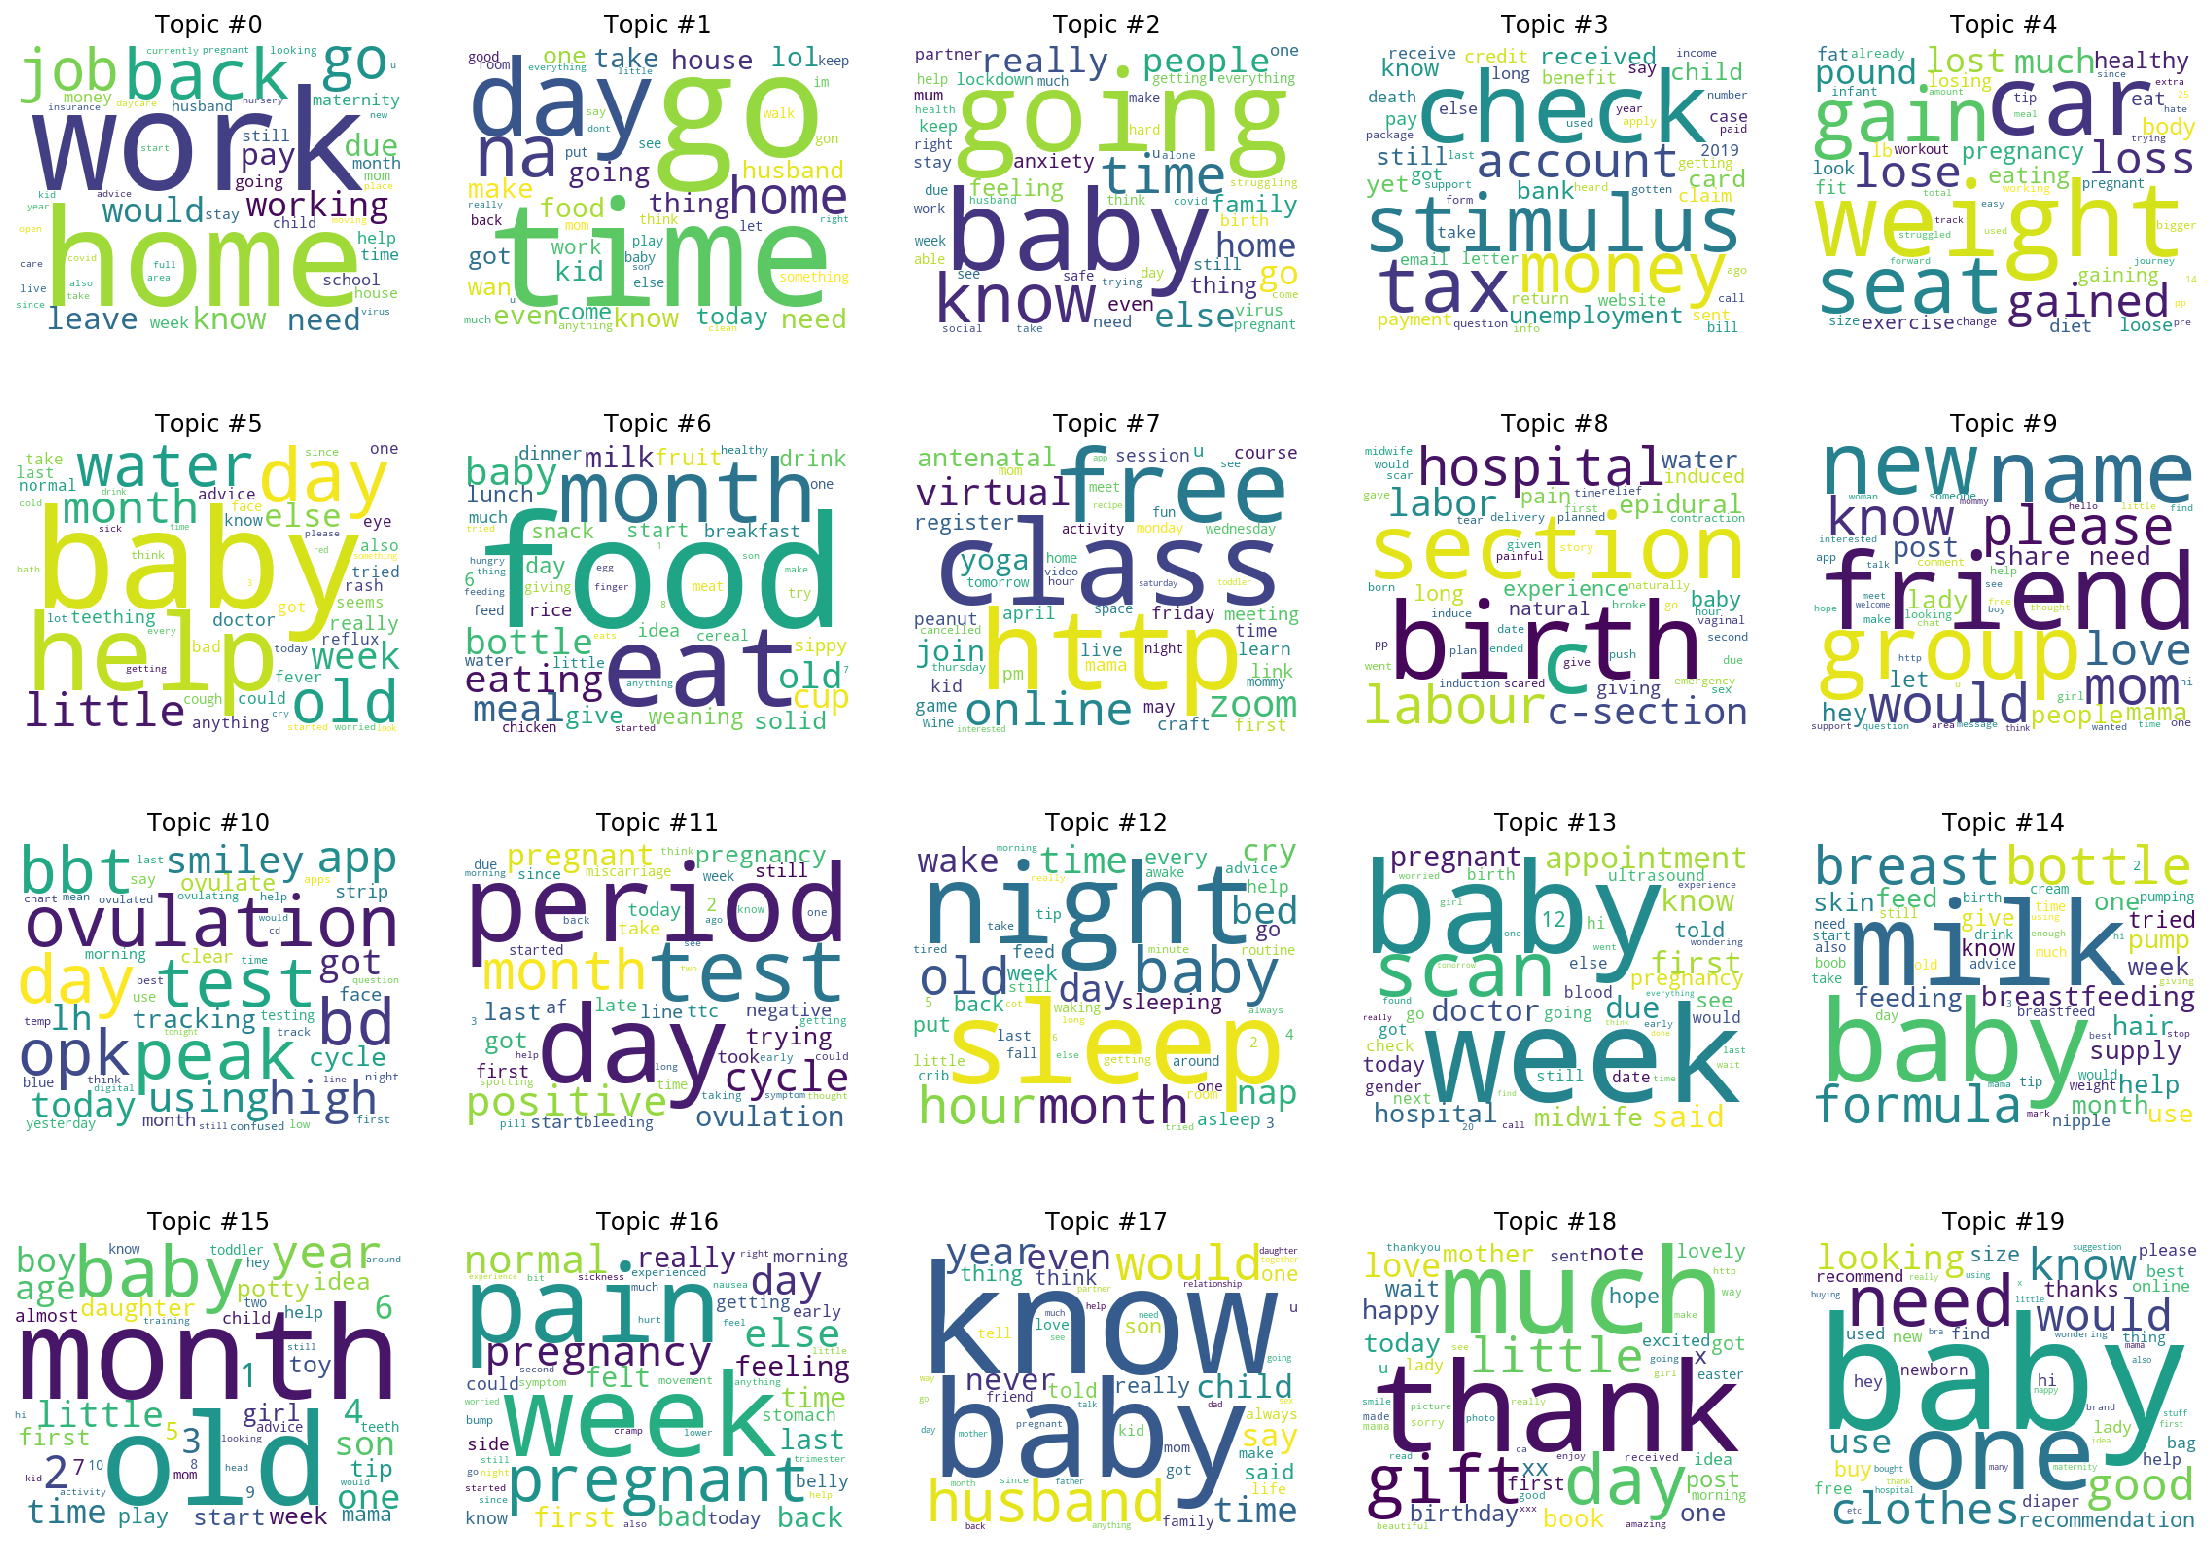

In [60]:
render_clouds(model2)

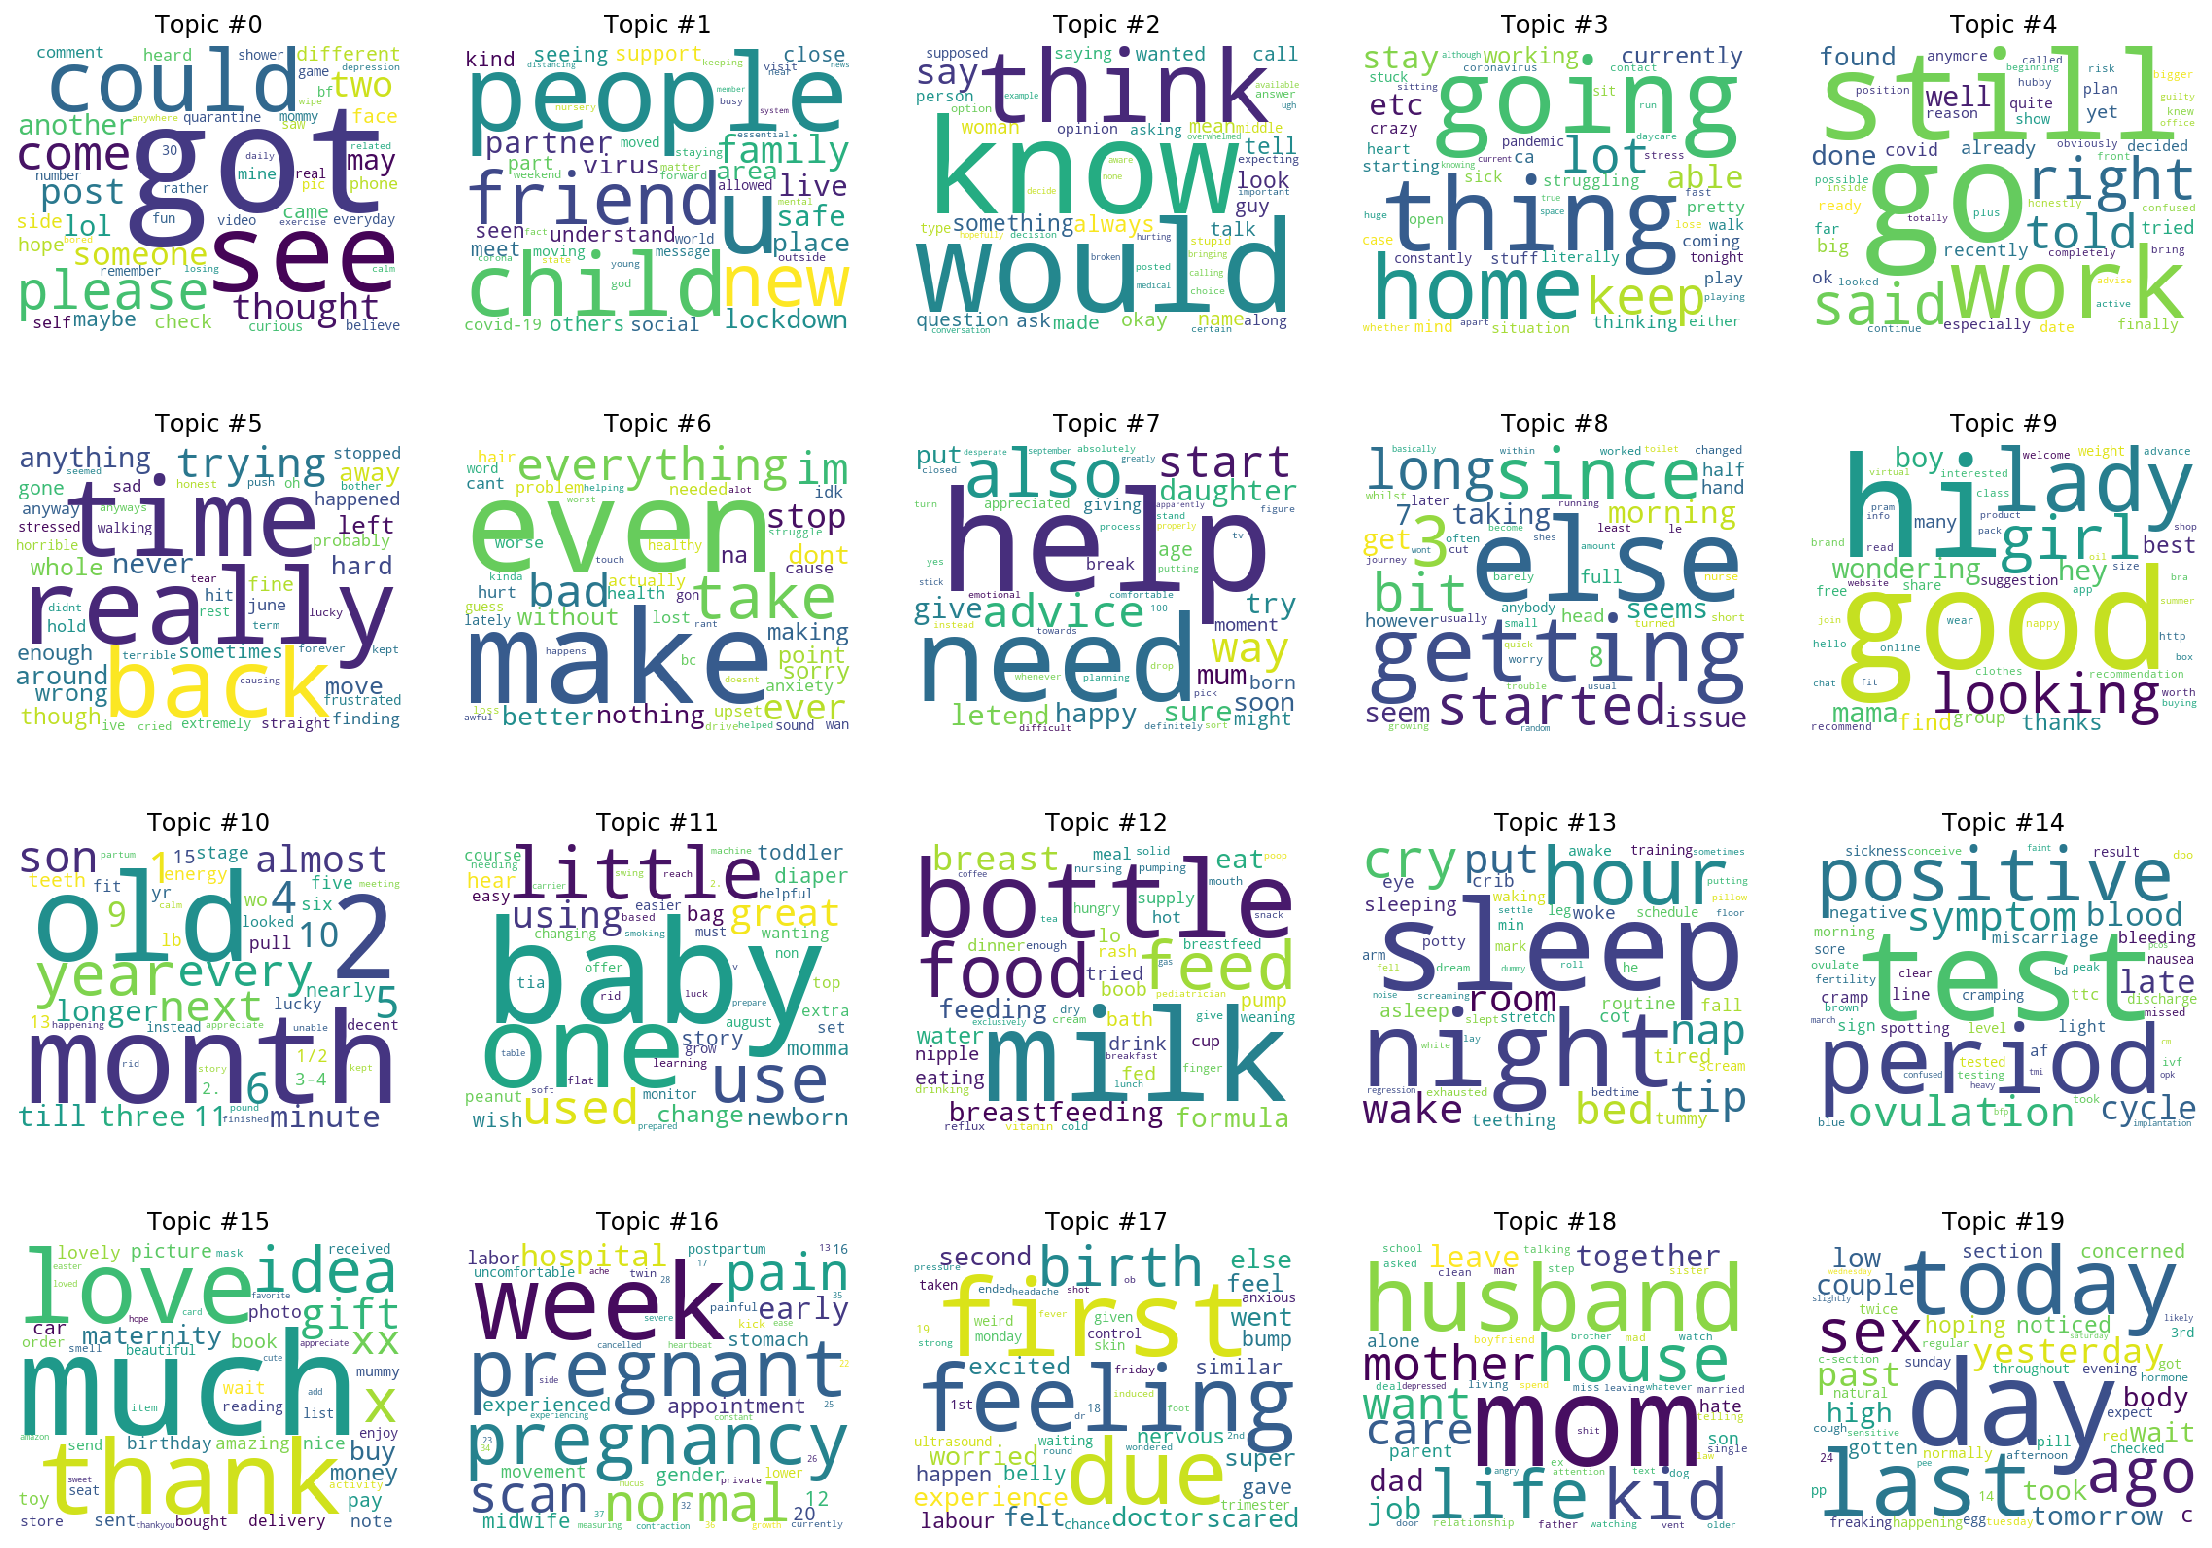

In [61]:
render_clouds(model3)

In [62]:
data = [
    eval_coherence(get_topic_words(model), gensim_dictionary, data_tokenized)
    for model in models
]

for idx, d in enumerate(data):
    print('Model %d overal coherence: %.1f%%' % (idx, 100 * d[0]))

Model 0 overal coherence: 57.6%
Model 1 overal coherence: 58.2%
Model 2 overal coherence: 61.0%
Model 3 overal coherence: 58.9%


100%|██████████| 89438/89438 [00:00<00:00, 520820.25it/s]


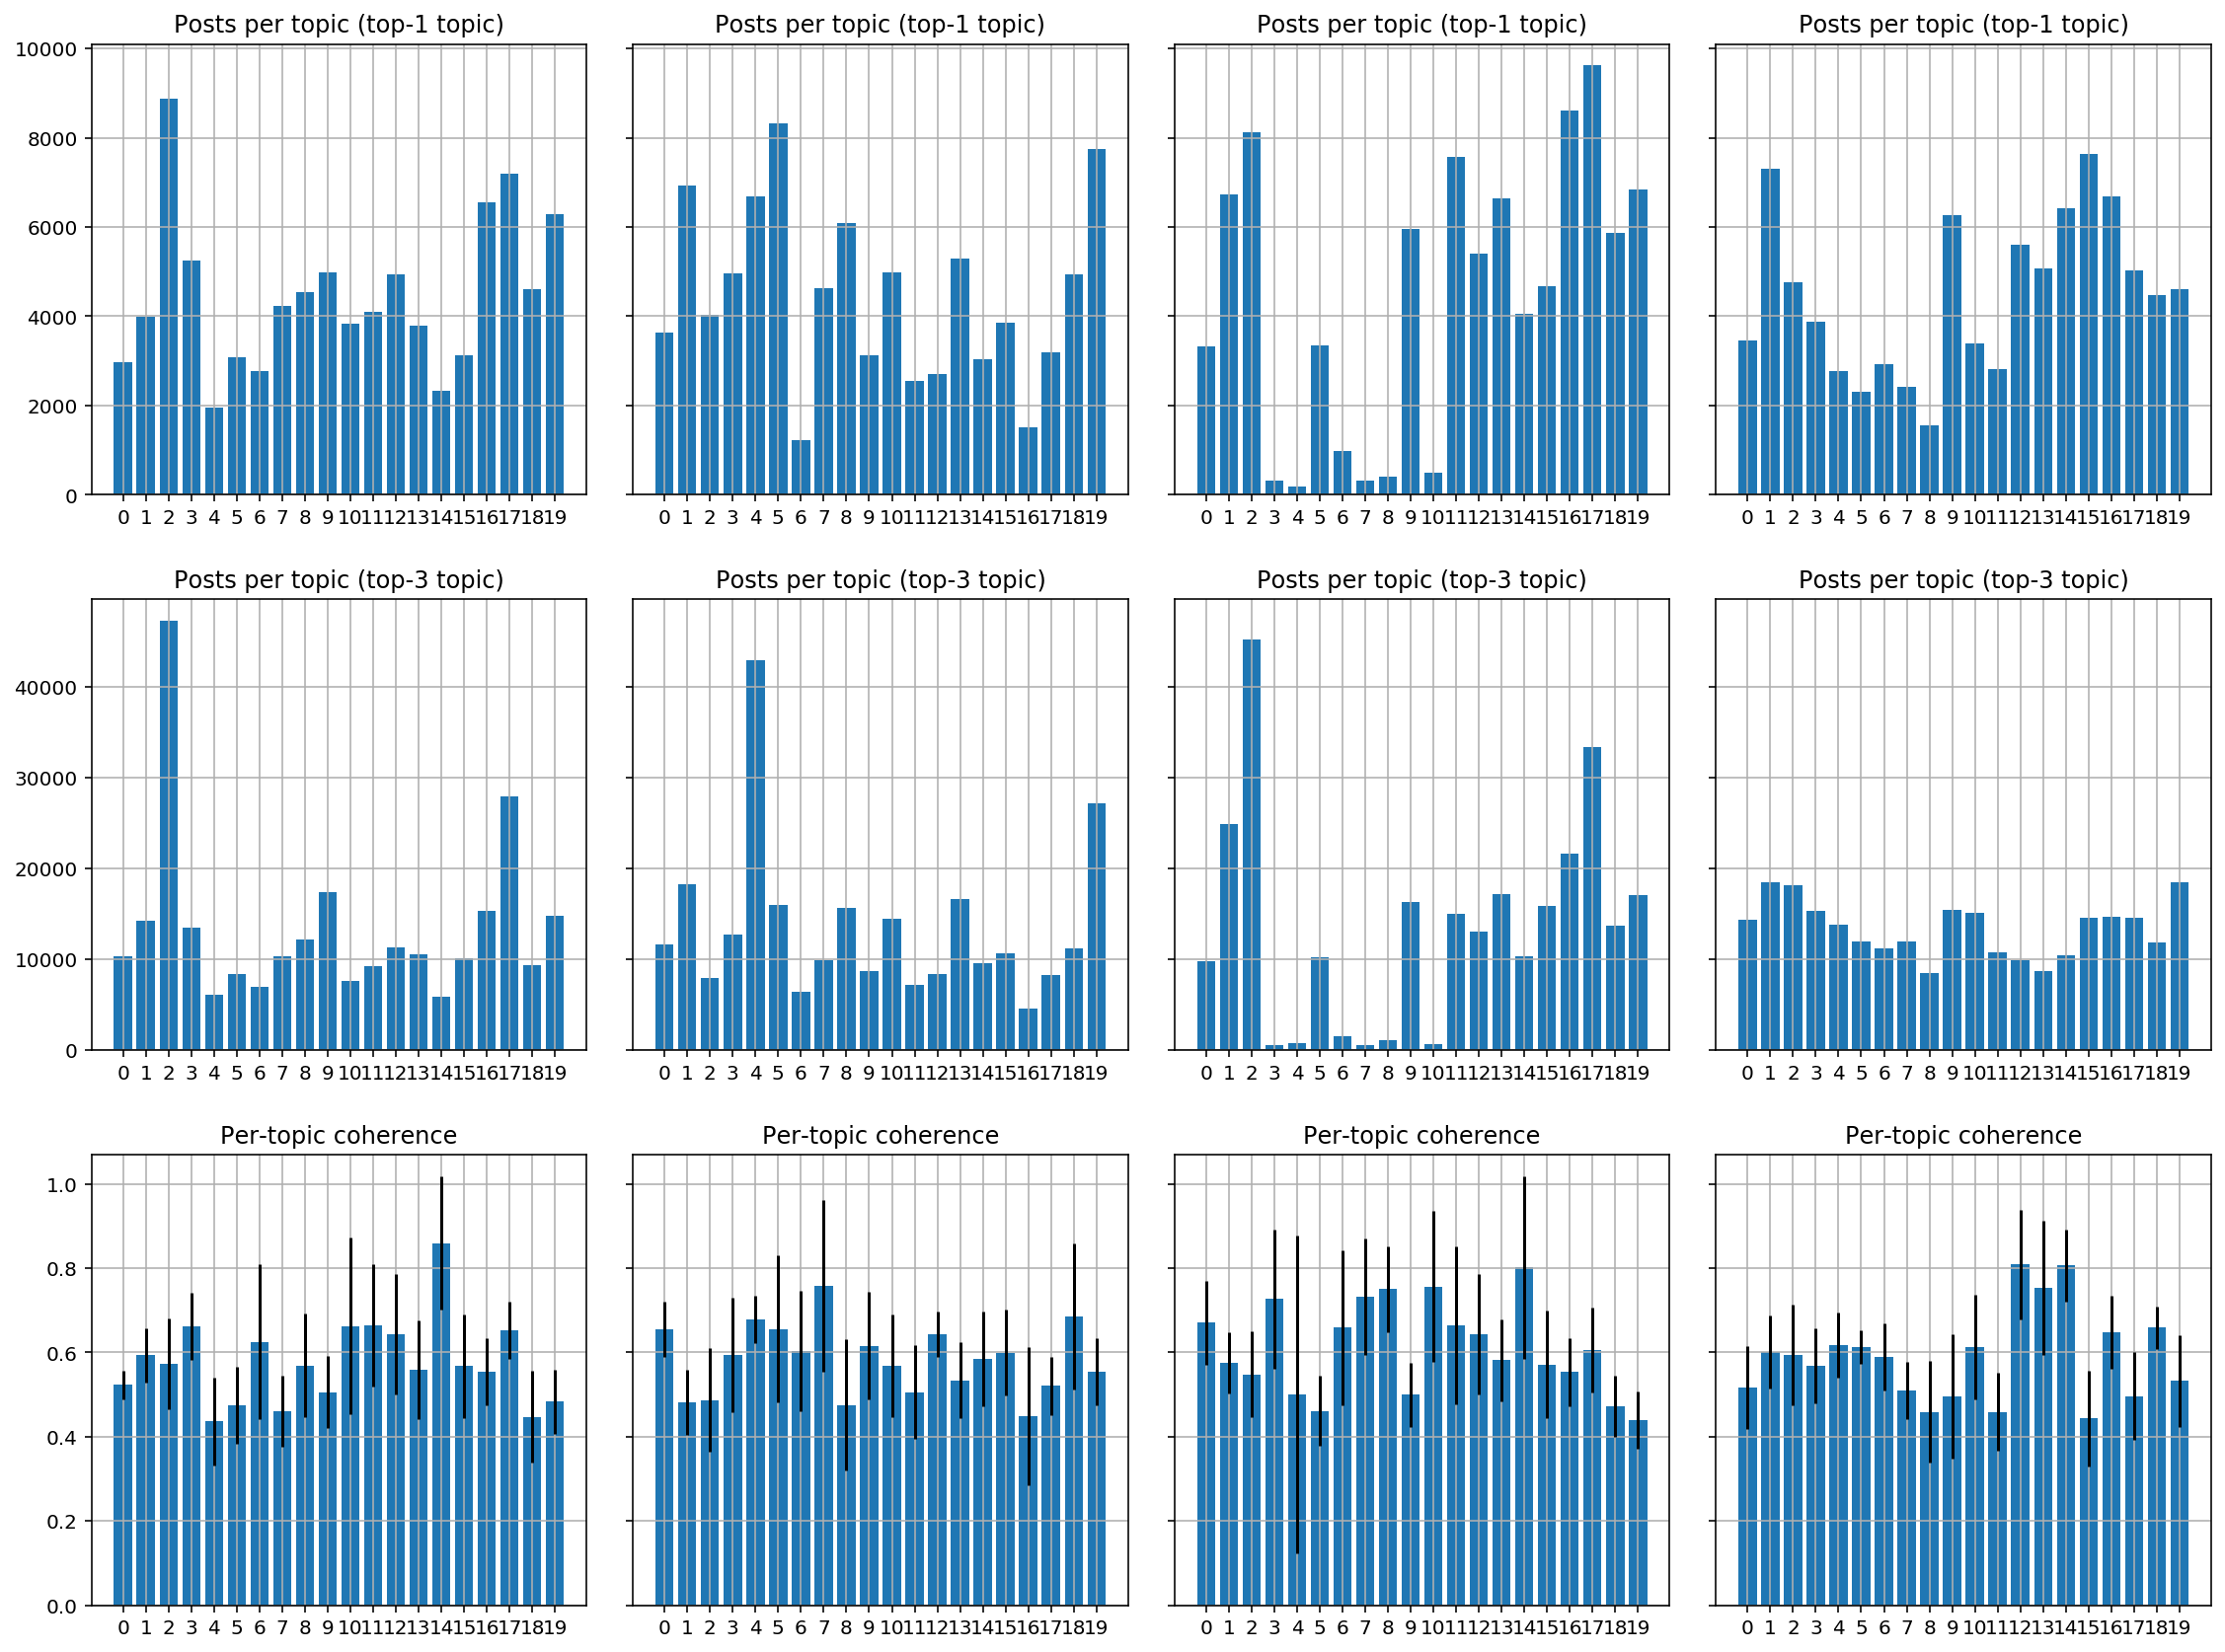

In [63]:
fig = plt.figure(figsize=(4 * len(models), 12))
axes = fig.subplots(
    nrows=3,
    ncols=len(models),
    sharey='row'
)

for idx,(d,m) in enumerate(zip(data,models)):
    plot_analysis(m, d, [a[idx] for a in axes])

fig.tight_layout(pad=2.0)
plt.show()